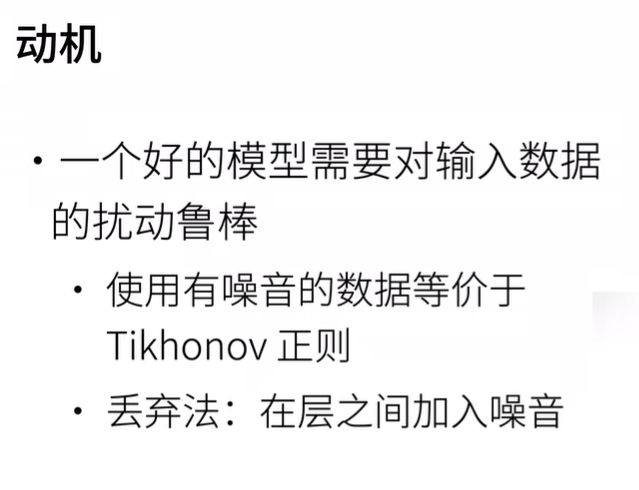

丢弃法实际上是一个正则


当面对更多的特征而样本不足时，线性模型往往会过拟合。 
相反，当给出更多样本而不是特征，通常线性模型不会过拟合。 
不幸的是，线性模型泛化的可靠性是有代价的。 
简单地说，线性模型没有考虑到特征之间的交互作用。 
对于每个特征，线性模型必须指定正的或负的权重，而忽略其他特征



暂退法（dropout）。 暂退法在前向传播过程中，计算每一内部层的同时注入噪声，这已经成为训练神经网络的常用技术。 这种方法之所以被称为暂退法，因为我们从表面上看是在训练过程中丢弃（drop out）一些神经元。 在整个训练过程的每一次迭代中，标准暂退法包括在计算下一层之前将当前层中的一些节点置零。

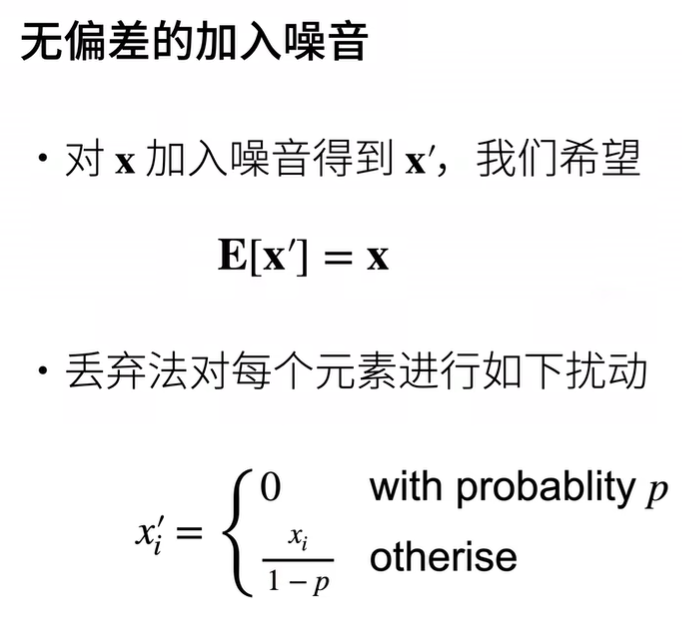

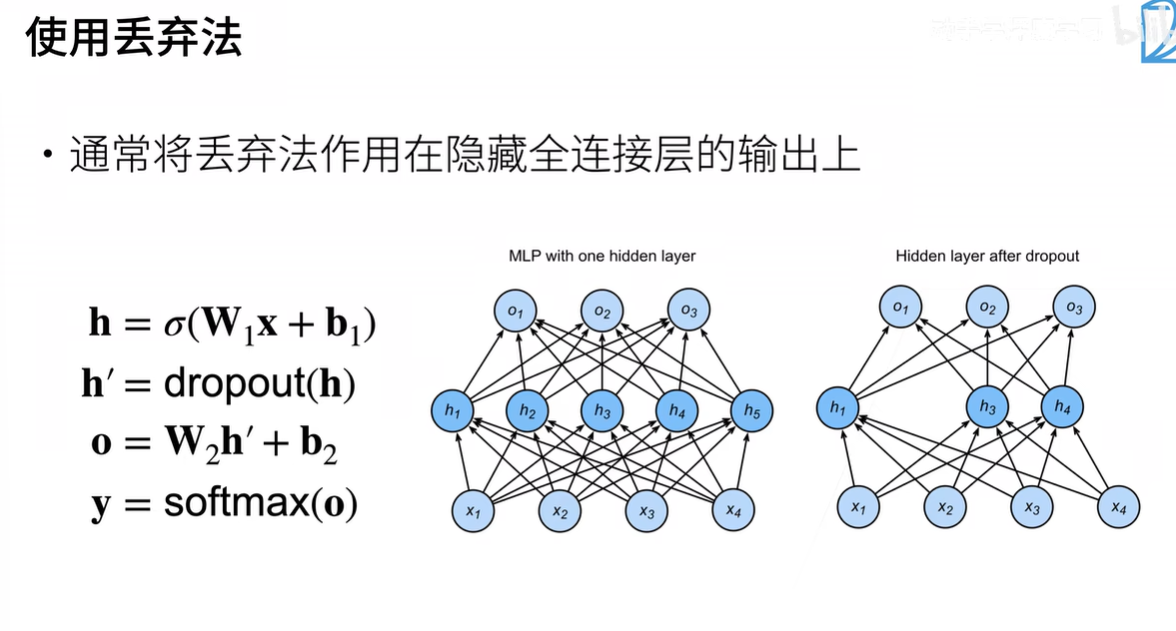

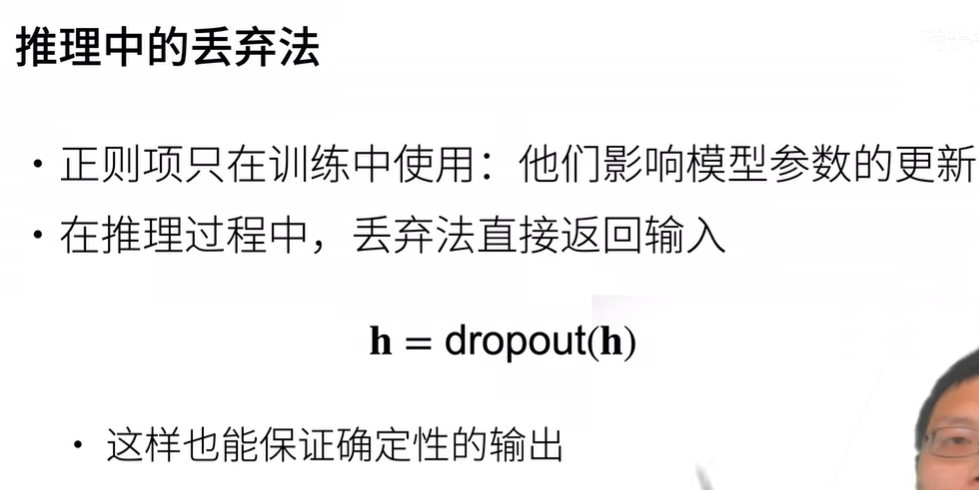

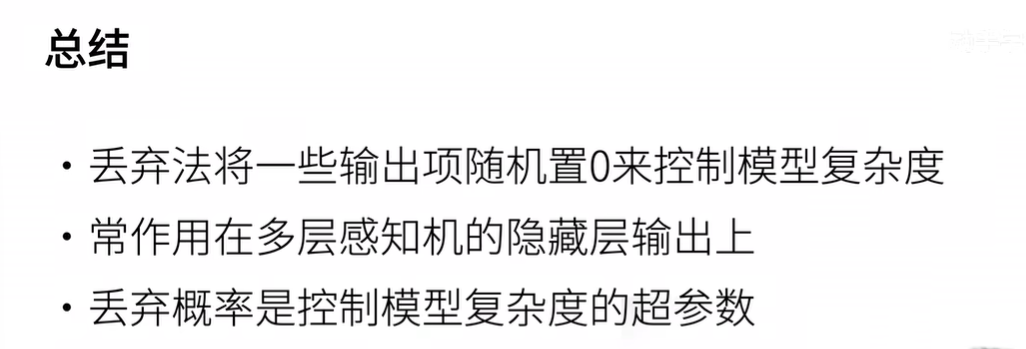

In [5]:
# 实现dropout函数 该函数作用是以dropout的概率丢弃张量x中的元素
import torch
from torch import nn
from d2l import torch as d2l

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    #随机的如果大于
    #生成一个0-1的均匀随机分布 如果大于概率 将其选出等于1 不然为0
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [6]:
#测试函数

X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  0.,  6.,  8., 10.,  0., 14.],
        [16., 18.,  0.,  0.,  0., 26., 28., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [8]:
#定义具有两个隐藏层的多层感知机 每个隐藏层包含256个单元

# 我们可以将暂退法应用于每个隐藏层的输出（在激活函数之后）， 
# 并且可以为每一层分别设置暂退概率： 
# 常见的技巧是在靠近输入层的地方设置较低的暂退概率。 
# 下面的模型将第一个和第二个隐藏层的暂退概率分别设置为0.2和0.5， 

# 并且暂退法只在训练期间有效
dropout1, dropout2 = 0.2, 0.5
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

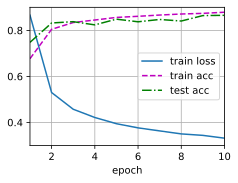

In [12]:
# 定义一个顺序容器 nn.Sequential
net = nn.Sequential(
    # 1. Flatten 层：将输入的 2D 图像（28x28）展开为 1D 向量（784）。
    nn.Flatten(), 
    
    # 2. 全连接层（线性层）：输入维度 784，输出维度 256。即将 784 维的输入映射到 256 维。
    nn.Linear(784, 256), 
    
    # 3. ReLU 激活函数：应用 Rectified Linear Unit 激活函数，引入非线性。
    nn.ReLU(),
    
    # 4. Dropout 层：在第一个全连接层之后添加一个 dropout 层，用于防止过拟合。
    #    dropout1 是一个占位符变量，表示在训练时该层每次随机丢弃的神经元比例。
    nn.Dropout(dropout1),
    
    # 5. 第二个全连接层：输入维度 256，输出维度 256。即将 256 维的输入映射到 256 维。
    nn.Linear(256, 256),
    
    # 6. ReLU 激活函数：再次应用 ReLU 激活函数，引入非线性。
    nn.ReLU(),
    
    # 7. Dropout 层：在第二个全连接层之后添加另一个 dropout 层。
    #    dropout2 是一个占位符变量，表示在训练时该层每次随机丢弃的神经元比例。
    nn.Dropout(dropout2),
    
    # 8. 第三个全连接层（输出层）：输入维度 256，输出维度 10。即将 256 维的输入映射到 10 维（类别数）。
    nn.Linear(256, 10)
)

# 定义一个权重初始化函数 init_weights，用于将线性层的权重参数用正态分布初始化。
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

# 应用权重初始化函数到网络的每一层
net.apply(init_weights)


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

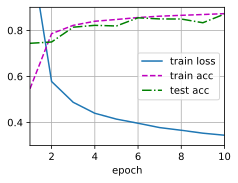

In [13]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)